In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import datetime
import gym
from collections import deque
from torch.distributions import Categorical

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)



In [ ]:
# Define the REINFORCE agent
class REINFORCEAgent():
    def __init__(self, state_size, action_size, seed, lr=0.01, with_baseline=False):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.with_baseline = with_baseline

        self.policy_network = PolicyNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)

        self.saved_log_probs = []
        self.rewards = []
        self.running_baseline = 0.0 if with_baseline else None  # Initialize running baseline if using with baseline

    def act(self, state,tau=1.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        logits = self.policy_network(state)
        # probs = torch.softmax(logits, dim=1)
        exp_logits = torch.exp(logits / tau)
        probs = exp_logits / torch.sum(exp_logits, dim=1)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()

    def learn(self, gamma):
        discounts = [gamma ** i for i in range(len(self.rewards) + 1)]
        returns = np.sum([a * b for a, b in zip(discounts, self.rewards)])

        if self.with_baseline:
            # Update running baseline
            self.running_baseline += (returns - self.running_baseline) / len(self.rewards)

            # Compute advantages by subtracting baseline
            advantages = returns - self.running_baseline
        else:
            advantages = returns  # No baseline used, so advantages are same as returns

        policy_loss = []
        for log_prob in self.saved_log_probs:
            policy_loss.append(-log_prob * advantages)
        policy_loss = torch.cat(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        self.saved_log_probs = []
        self.rewards = []

    def step(self, state, action, reward):
        self.saved_log_probs.append(action)
        self.rewards.append(reward)

    def reset(self):
        self.saved_log_probs = []
        self.rewards = []
        if self.with_baseline:
            self.running_baseline = 0.0

In [ ]:
# MC-REINFORCE without baseline
class MC_REINFORCEWithoutBaseline(REINFORCEAgent):
    def __init__(self, state_size, action_size, seed, lr=0.01):
        super(MC_REINFORCEWithoutBaseline, self).__init__(state_size, action_size, seed, lr, with_baseline=False)

# MC-REINFORCE with baseline
class MC_REINFORCEWithBaseline(REINFORCEAgent):
    def __init__(self, state_size, action_size, seed, lr=0.01):
        super(MC_REINFORCEWithBaseline, self).__init__(state_size, action_size, seed, lr, with_baseline=True)

In [ ]:
# Define the REINFORCE algorithm
def reinforce(env, agent, n_episodes=10000, max_t=1000, gamma=0.99):
    scores_window = deque(maxlen=100)
    rewards = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.rewards.append(reward)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        rewards.append(score)

        agent.learn(gamma)

        if i_episode % 50 == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window) >= -107.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break

    return rewards


In [27]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
# seed = [0,20,42,123,2024]
seed = [10,30,42,123,2024]  # 10,30,42,123,2024


# Define hyperparameters
LR = 5e-04  # Learning rate
gamma = 0.99  # Discount factor
n_episodes = 1000  # Maximum number of episodes
max_t = 10000  # Maximum number of timesteps per episode

# Define the environment
# Replace 'CartPole-v1' with the name of your environment
env = gym.make('Acrobot-v1')  # Example environment (CartPole-v1)

# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Create an instance of the REINFORCE agent

results1 = []
results2 = []

# Run the REINFORCE algorithm for each seed
for s in seed:
  print("For seed : ",s)
  env.reset()
  random.seed(s)
  np.random.seed(s)
  torch.manual_seed(s)
  agent1 = MC_REINFORCEWithoutBaseline(state_size, action_size, seed=s, lr=LR)
  agent2 = MC_REINFORCEWithBaseline(state_size, action_size, seed=s, lr=LR)
  begin_time = datetime.datetime.now()
  rewards1 = reinforce(env, agent1, n_episodes=n_episodes, max_t=max_t, gamma=gamma)
  results1.append(rewards1)
  time_taken1 = datetime.datetime.now() - begin_time
  print("For seed : ",s," - MC reinforce with baseline")
  env.reset()
  begin_time2 = datetime.datetime.now()
  rewards2 = reinforce(env, agent2, n_episodes=n_episodes, max_t=max_t, gamma=gamma)
  results2.append(rewards2)
  time_taken2 = datetime.datetime.now() - begin_time2
  print("Time taken1: ", time_taken1," Time taken2: ",time_taken2)

# Close the environment
env.close()

For seed :  10
Episode: 50	Average Score: -459.90
Episode: 100	Average Score: -385.23
Episode: 150	Average Score: -290.35
Episode: 200	Average Score: -278.83
Episode: 250	Average Score: -318.38
Episode: 300	Average Score: -356.75
Episode: 350	Average Score: -290.68
Episode: 400	Average Score: -193.47
Episode: 450	Average Score: -163.28
Episode: 500	Average Score: -151.99
Episode: 550	Average Score: -156.35
Episode: 600	Average Score: -172.30
Episode: 650	Average Score: -185.58
Episode: 700	Average Score: -190.54
Episode: 750	Average Score: -180.81
Episode: 800	Average Score: -181.12
Episode: 850	Average Score: -196.55
Episode: 900	Average Score: -202.91
Episode: 950	Average Score: -240.24
Episode: 1000	Average Score: -288.85
For seed :  10  - MC reinforce with baseline
Episode: 50	Average Score: -496.78
Episode: 100	Average Score: -498.39
Episode: 150	Average Score: -500.00
Episode: 200	Average Score: -500.00
Episode: 250	Average Score: -500.00
Episode: 300	Average Score: -500.00
Episo

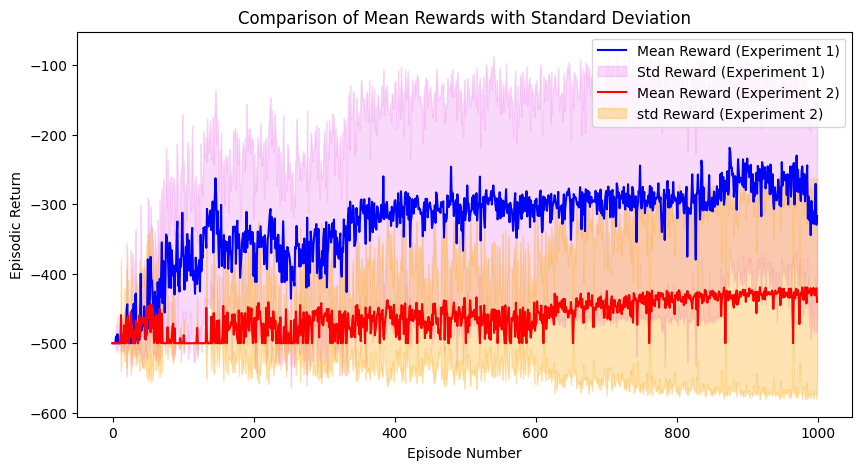

In [28]:
import matplotlib.pyplot as plt




plt.figure(figsize=(10, 5))
# Calculate mean and variance across 5 runs for each episode
mean_rewards1 = np.mean(results1, axis=0)
std_rewards1 = np.std(results1, axis=0)


mean_rewards2 = np.mean(results2, axis=0)
std_rewards2 = np.std(results2, axis=0)

# Plot mean rewards
plt.plot(mean_rewards1, label='Mean Reward (Experiment 1)',color = 'blue')

# Plot upper and lower bounds of variance as separate lines
# plt.plot(mean_rewards + std_rewards, linestyle='--', color='orange', label='Upper Bound (Mean + Std)')
# plt.plot(mean_rewards - std_rewards, linestyle='--', color='green', label='Lower Bound (Mean - Std)')

# Fill the area between (mean - std) and (mean + std)
plt.fill_between(range(len(mean_rewards1)), mean_rewards1 - std_rewards1, mean_rewards1 + std_rewards1,color='violet', label='Std Reward (Experiment 1)',alpha=0.3)

plt.plot(mean_rewards2, label='Mean Reward (Experiment 2)', color='red')
plt.fill_between(range(len(mean_rewards2)), mean_rewards2 - std_rewards2, mean_rewards2 + std_rewards2, color='orange', label='std Reward (Experiment 2)', alpha=0.3)


# Add labels and title
plt.xlabel('Episode Number')
plt.ylabel('Episodic Return')
# plt.title("Title")
plt.title('Comparison of Mean Rewards with Standard Deviation')

# Add legend
plt.legend()

# Show plot
plt.show()